In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests as req
import plotly as py
from dotenv import load_dotenv
import os


In [3]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [5]:
r = req.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

MissingSchema: Invalid URL 'None/registrations': No scheme supplied. Perhaps you meant https://None/registrations?

In [7]:
r2 = req.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

MissingSchema: Invalid URL 'None/visits': No scheme supplied. Perhaps you meant https://None/visits?

In [9]:
r = r.json()

NameError: name 'r' is not defined

In [11]:
os.makedirs('./charts')

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: './charts'

In [13]:
df3 = pd.DataFrame(data = r)

NameError: name 'r' is not defined

In [23]:
r2 = r2.json()

In [25]:
df4 = pd.DataFrame(data = r2)

In [31]:
df3['date_group'] = pd.to_datetime(df3['datetime']).dt.date

In [35]:
df4['date_group'] = pd.to_datetime(df4['datetime']).dt.date

In [39]:
df4filtered = df4[~df4['user_agent'].str.contains('bot')]

In [43]:
df3group = df3.groupby(['date_group', 'platform'], as_index = False).agg({'user_id': 'count'})

In [47]:
df4filtered = df4filtered.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset=['visit_id'], keep='last', inplace = True)

In [48]:
df4group = df4filtered.groupby(['date_group', 'platform'], as_index = False).agg({'visit_id': 'count'})

In [155]:
df_merged = pd.merge(
    df4group, df3group,
    on= ['date_group', 'platform']
)

In [159]:
df_merged['conversion'] = df_merged['user_id'] * 100 / df_merged['visit_id']

In [163]:
df_merged = df_merged.dropna()
df_merged = df_merged.sort_values(['date_group'])
df_merged = df_merged.rename(columns = {'user_id': 'registrations'})

,createddate,platform,visit_id,user_id,conversion
335,2023-06-20,web,1145,9,0.007860
2,2023-03-01,web,844,8,0.009479
425,2023-07-20,web,1158,12,0.010363
281,2023-06-02,web,1087,12,0.011040
137,2023-04-15,web,987,11,0.011145
...,...,...,...,...,...
156,2023-04-22,android,56,52,0.928571
148,2023-04-19,ios,28,26,0.928571
184,2023-05-01,ios,15,14,0.933333
198,2023-05-06,android,64,61,0.953125


In [165]:
df_merged.to_json('./conversion.json')

In [169]:
dfads = pd.read_csv('./ads.csv')

In [173]:
dfads['date_group'] = pd.to_datetime(dfads['date']).dt.date

In [175]:
dfadsgroup = dfads.groupby(['date_group'], as_index = False).agg({'cost': 'sum'})

In [179]:
dfadsgroup.sort_values(['cost'])

,createddate,cost
13,2023-03-14,100
133,2023-08-23,101
136,2023-08-26,102
89,2023-06-30,102
104,2023-07-15,103
...,...,...
39,2023-04-18,289
15,2023-03-25,293
124,2023-08-14,297
16,2023-03-26,298


In [183]:
df_mergedgroup = df_merged.groupby(['date_group']).agg({'visit_id': 'sum', 'registrations': 'sum'})

In [185]:
adsdfmerge = pd.merge(
    df_mergedgroup, dfadsgroup,
    on= ['date_group'],
    how='left'
)

In [239]:
adsdfmerge['conversion'] = adsdfmerge['registrations'] / adsdfmerge['visit_id']

In [241]:
adsdfmerge.to_json('./ads.json')

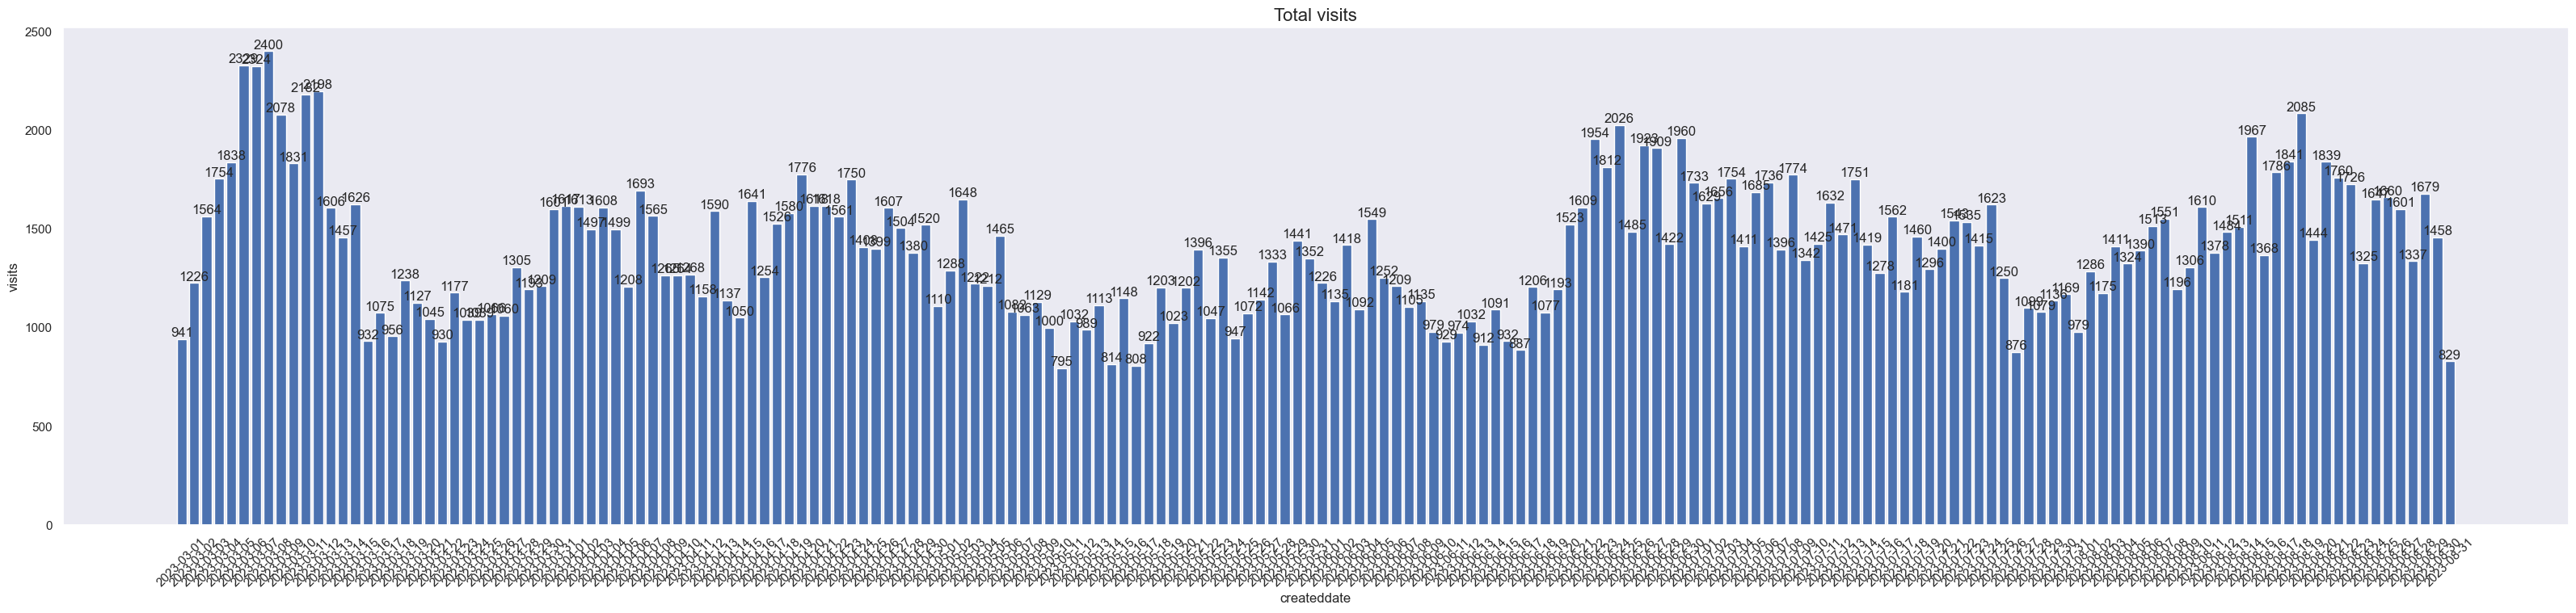

In [531]:
plt.figure(figsize=(40,8))
plt.title('Total visits', fontsize=16)
bars = plt.bar(adsdfmerge['date_group'], adsdfmerge['visit_id'])
plt.bar_label(bars, labels=None, fmt='%g', label_type='edge', padding=0)
plt.xticks(adsdfmerge['date_group'], rotation=45)
plt.xlabel('date_group')
plt.ylabel('visits')
plt.grid()
plt.savefig(f'./charts/chart1.png')
plt.show()


In [293]:
df_mergedcopy = df_merged.copy()

In [295]:
df_mergedcopy = df_mergedcopy[['date_group', 'platform', 'visit_id']]
df_mergedcopy

,createddate,platform,visit_id
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,844
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
547,2023-08-30,ios,66
548,2023-08-30,web,1357
549,2023-08-31,android,57
550,2023-08-31,ios,50


In [297]:
df_mergedcopy.set_index(['date_group', 'platform'], inplace=True)

In [299]:
df_mergedcopy = df_mergedcopy.unstack(fill_value=0)

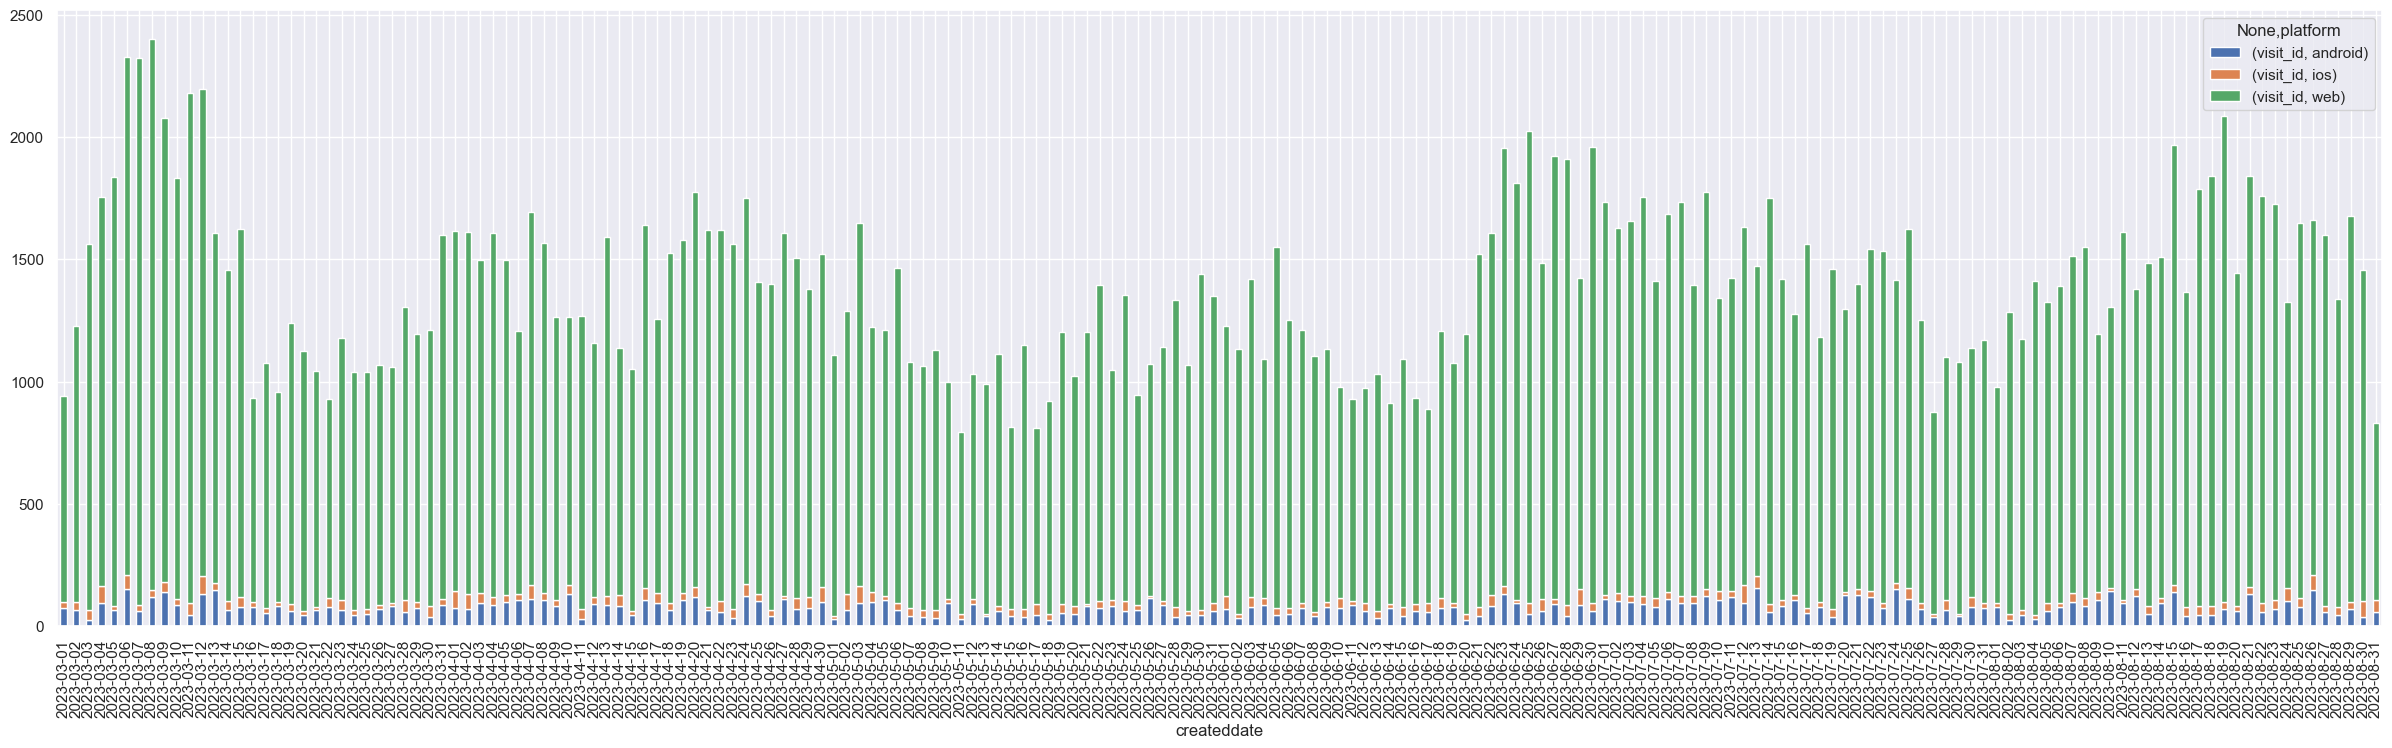

In [533]:
df_mergedcopy.plot(kind='bar', figsize=(30,8), stacked=True)
plt.savefig(f'./charts/chart2.png')

In [307]:
df_mergedcop2 = df_merged.copy()

In [309]:
df_mergedcop2 = df_mergedcop2[['date_group', 'platform', 'registrations']]

In [311]:
df_mergedcop2.set_index(['date_group', 'platform'], inplace=True)

In [313]:
df_mergedcop2 = df_mergedcop2.unstack(fill_value=0)

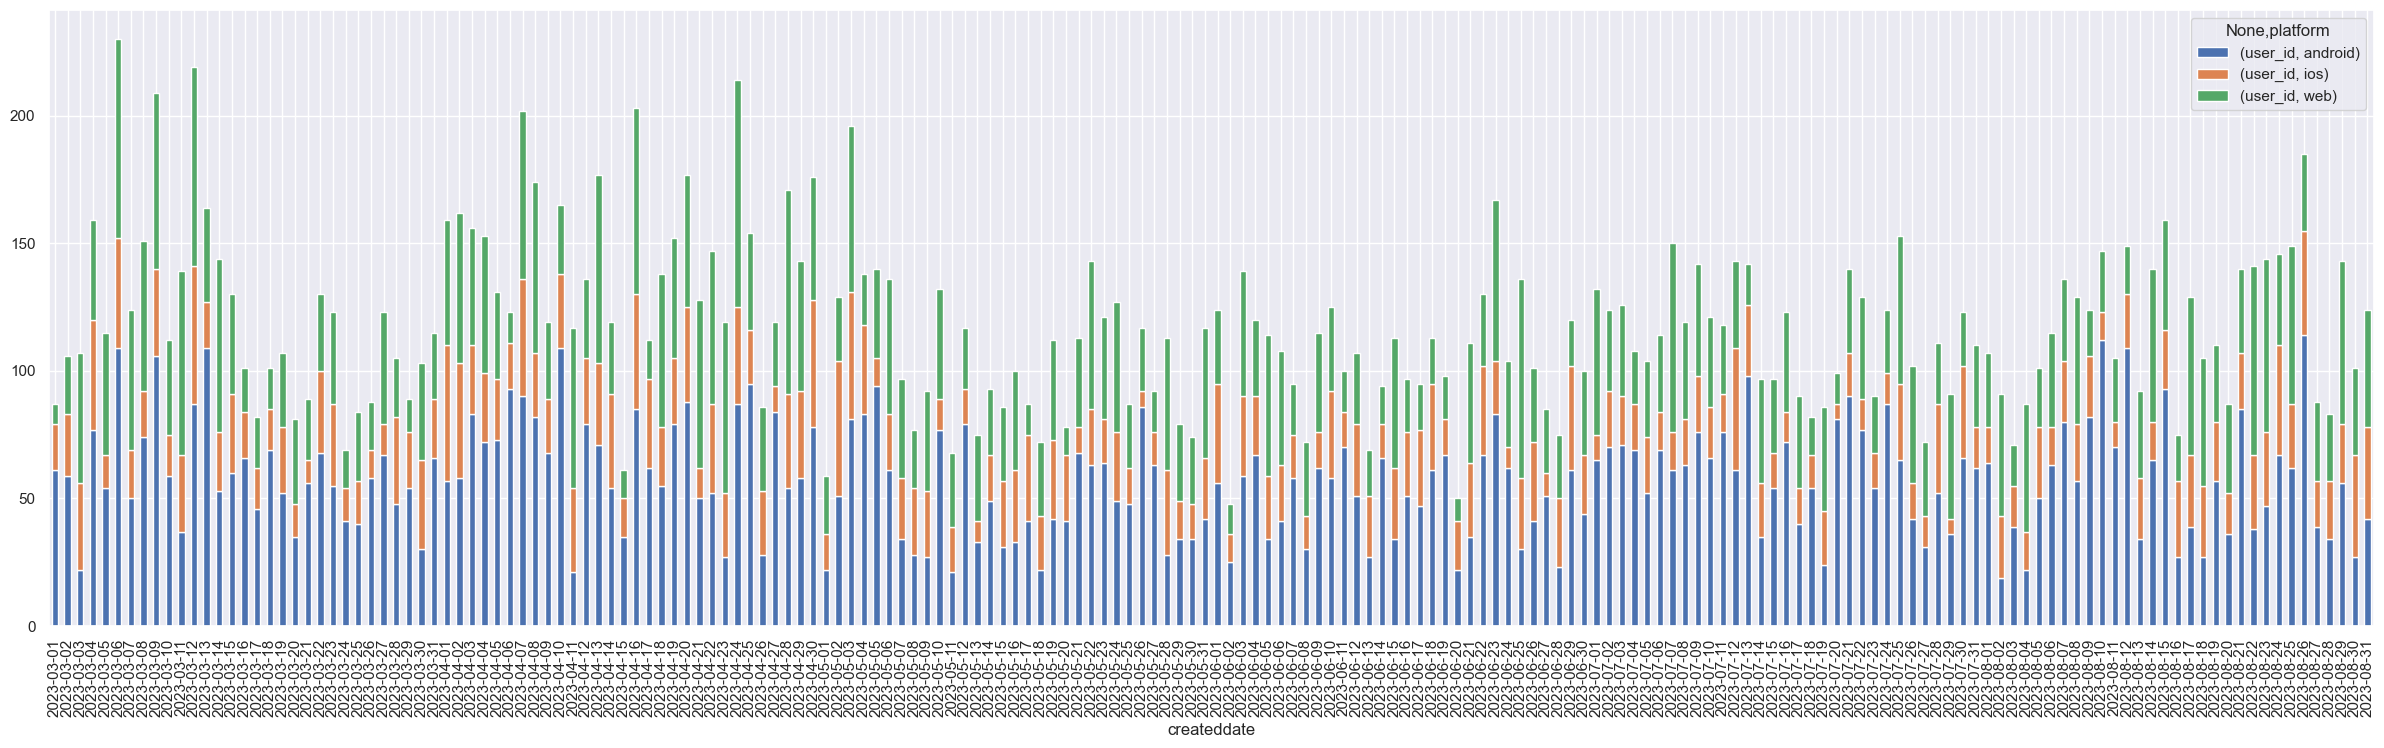

In [535]:
df_mergedcop2.plot(kind='bar', figsize=(30,8), stacked=True)
plt.savefig(f'./charts/chart3.png')

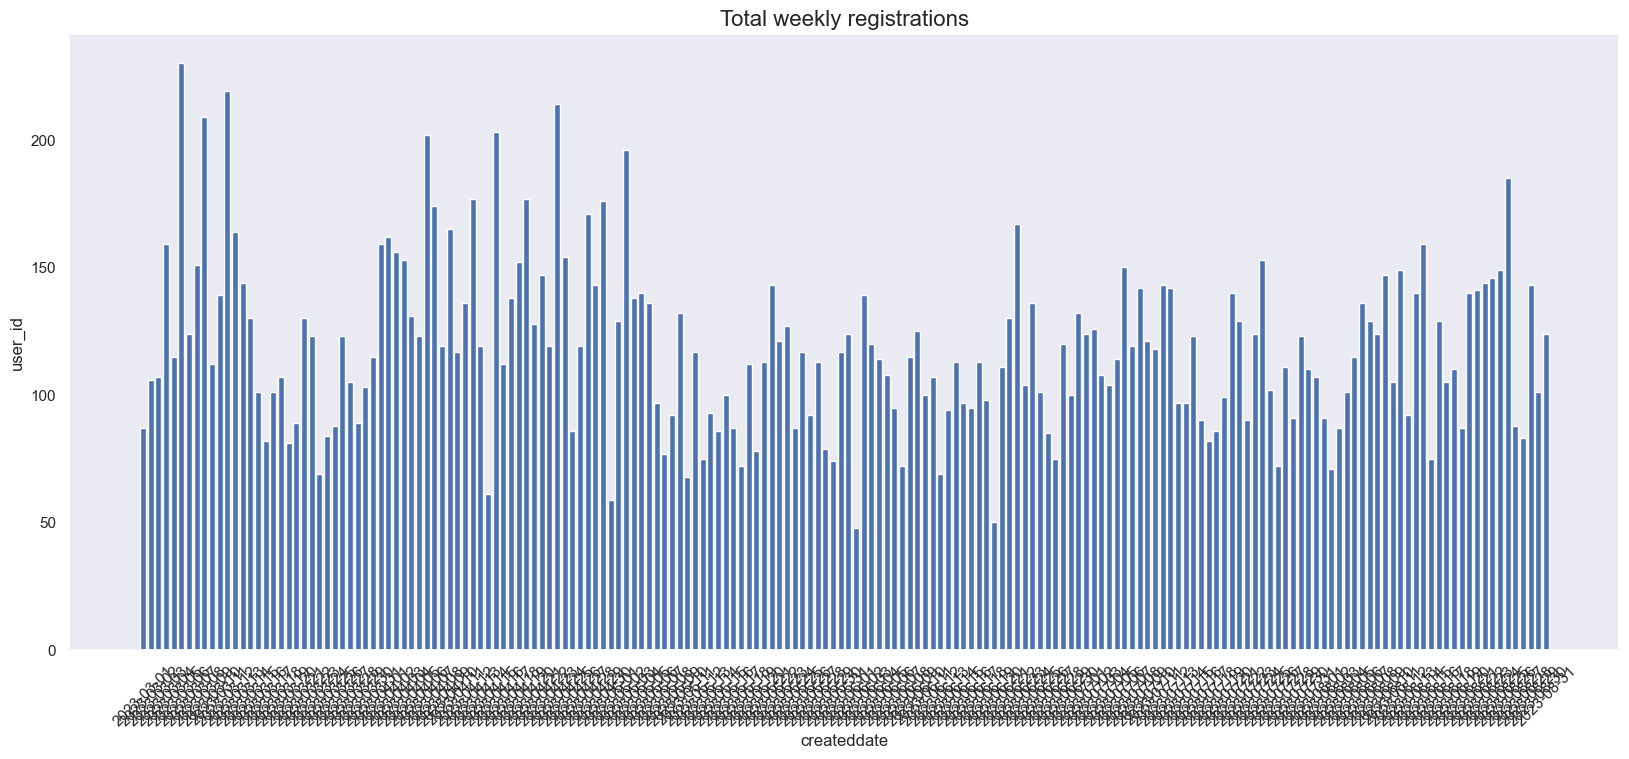

In [537]:
plt.figure(figsize=(20,8))
plt.title('Total weekly registrations', fontsize=16)
plt.bar(adsdfmerge['date_group'], adsdfmerge['registrations'])
plt.xticks(adsdfmerge['date_group'], rotation=45)
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.grid()
plt.savefig(f'./charts/chart4.png')
plt.show()


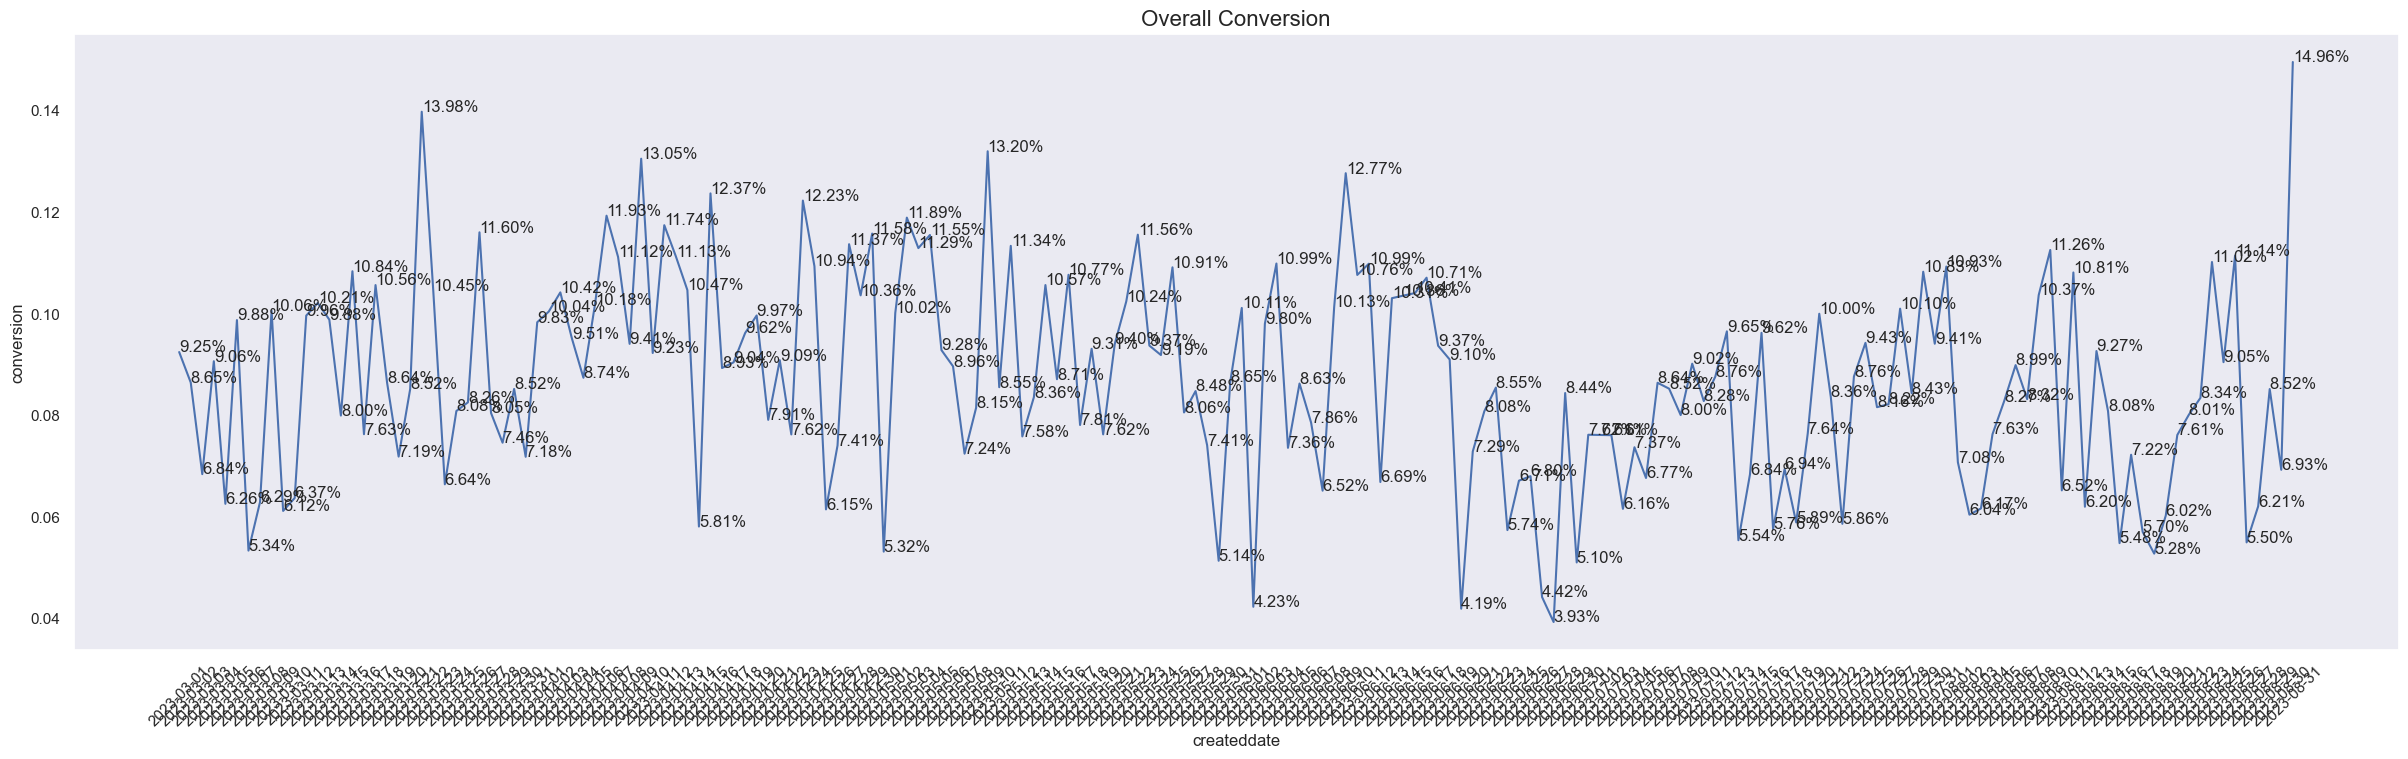

In [539]:
plt.figure(figsize=(30,8))
plt.title('Overall Conversion', fontsize=16)
plt.plot(adsdfmerge['date_group'], adsdfmerge['conversion'])
for i, y in adsdfmerge.iterrows():
    plt.text(y['date_group'], y['conversion'], f'{y["conversion"]*100:.2f}%')
plt.xticks(adsdfmerge['date_group'], rotation=45)
plt.xlabel('date_group')
plt.ylabel('conversion')
plt.grid()
plt.savefig(f'./charts/chart5.png')
plt.show()


In [319]:
adsdfmerge

,createddate,visit_id,user_id,cost,conversion
0,2023-03-01,941,87,212.0,0.092455
1,2023-03-02,1226,106,252.0,0.086460
2,2023-03-03,1564,107,202.0,0.068414
3,2023-03-04,1754,159,223.0,0.090650
4,2023-03-05,1838,115,265.0,0.062568
...,...,...,...,...,...
179,2023-08-27,1601,88,222.0,0.054966
180,2023-08-28,1337,83,223.0,0.062079
181,2023-08-29,1679,143,190.0,0.085170
182,2023-08-30,1458,101,109.0,0.069273


In [379]:
df_mergedc3 = df_merged.copy()

In [385]:
df_mergedc3 = df_mergedc3.groupby(['date_group', 'platform']).agg({'visit_id': 'sum', 'registrations': 'sum'})

In [389]:
df_mergedc3 = df_mergedc3.reset_index()

In [391]:
df_mergedc3['conversion'] = df_mergedc3['registrations'] / df_mergedc3['visit_id']

In [369]:
adsdfmergenona = adsdfmerge.fillna(0)

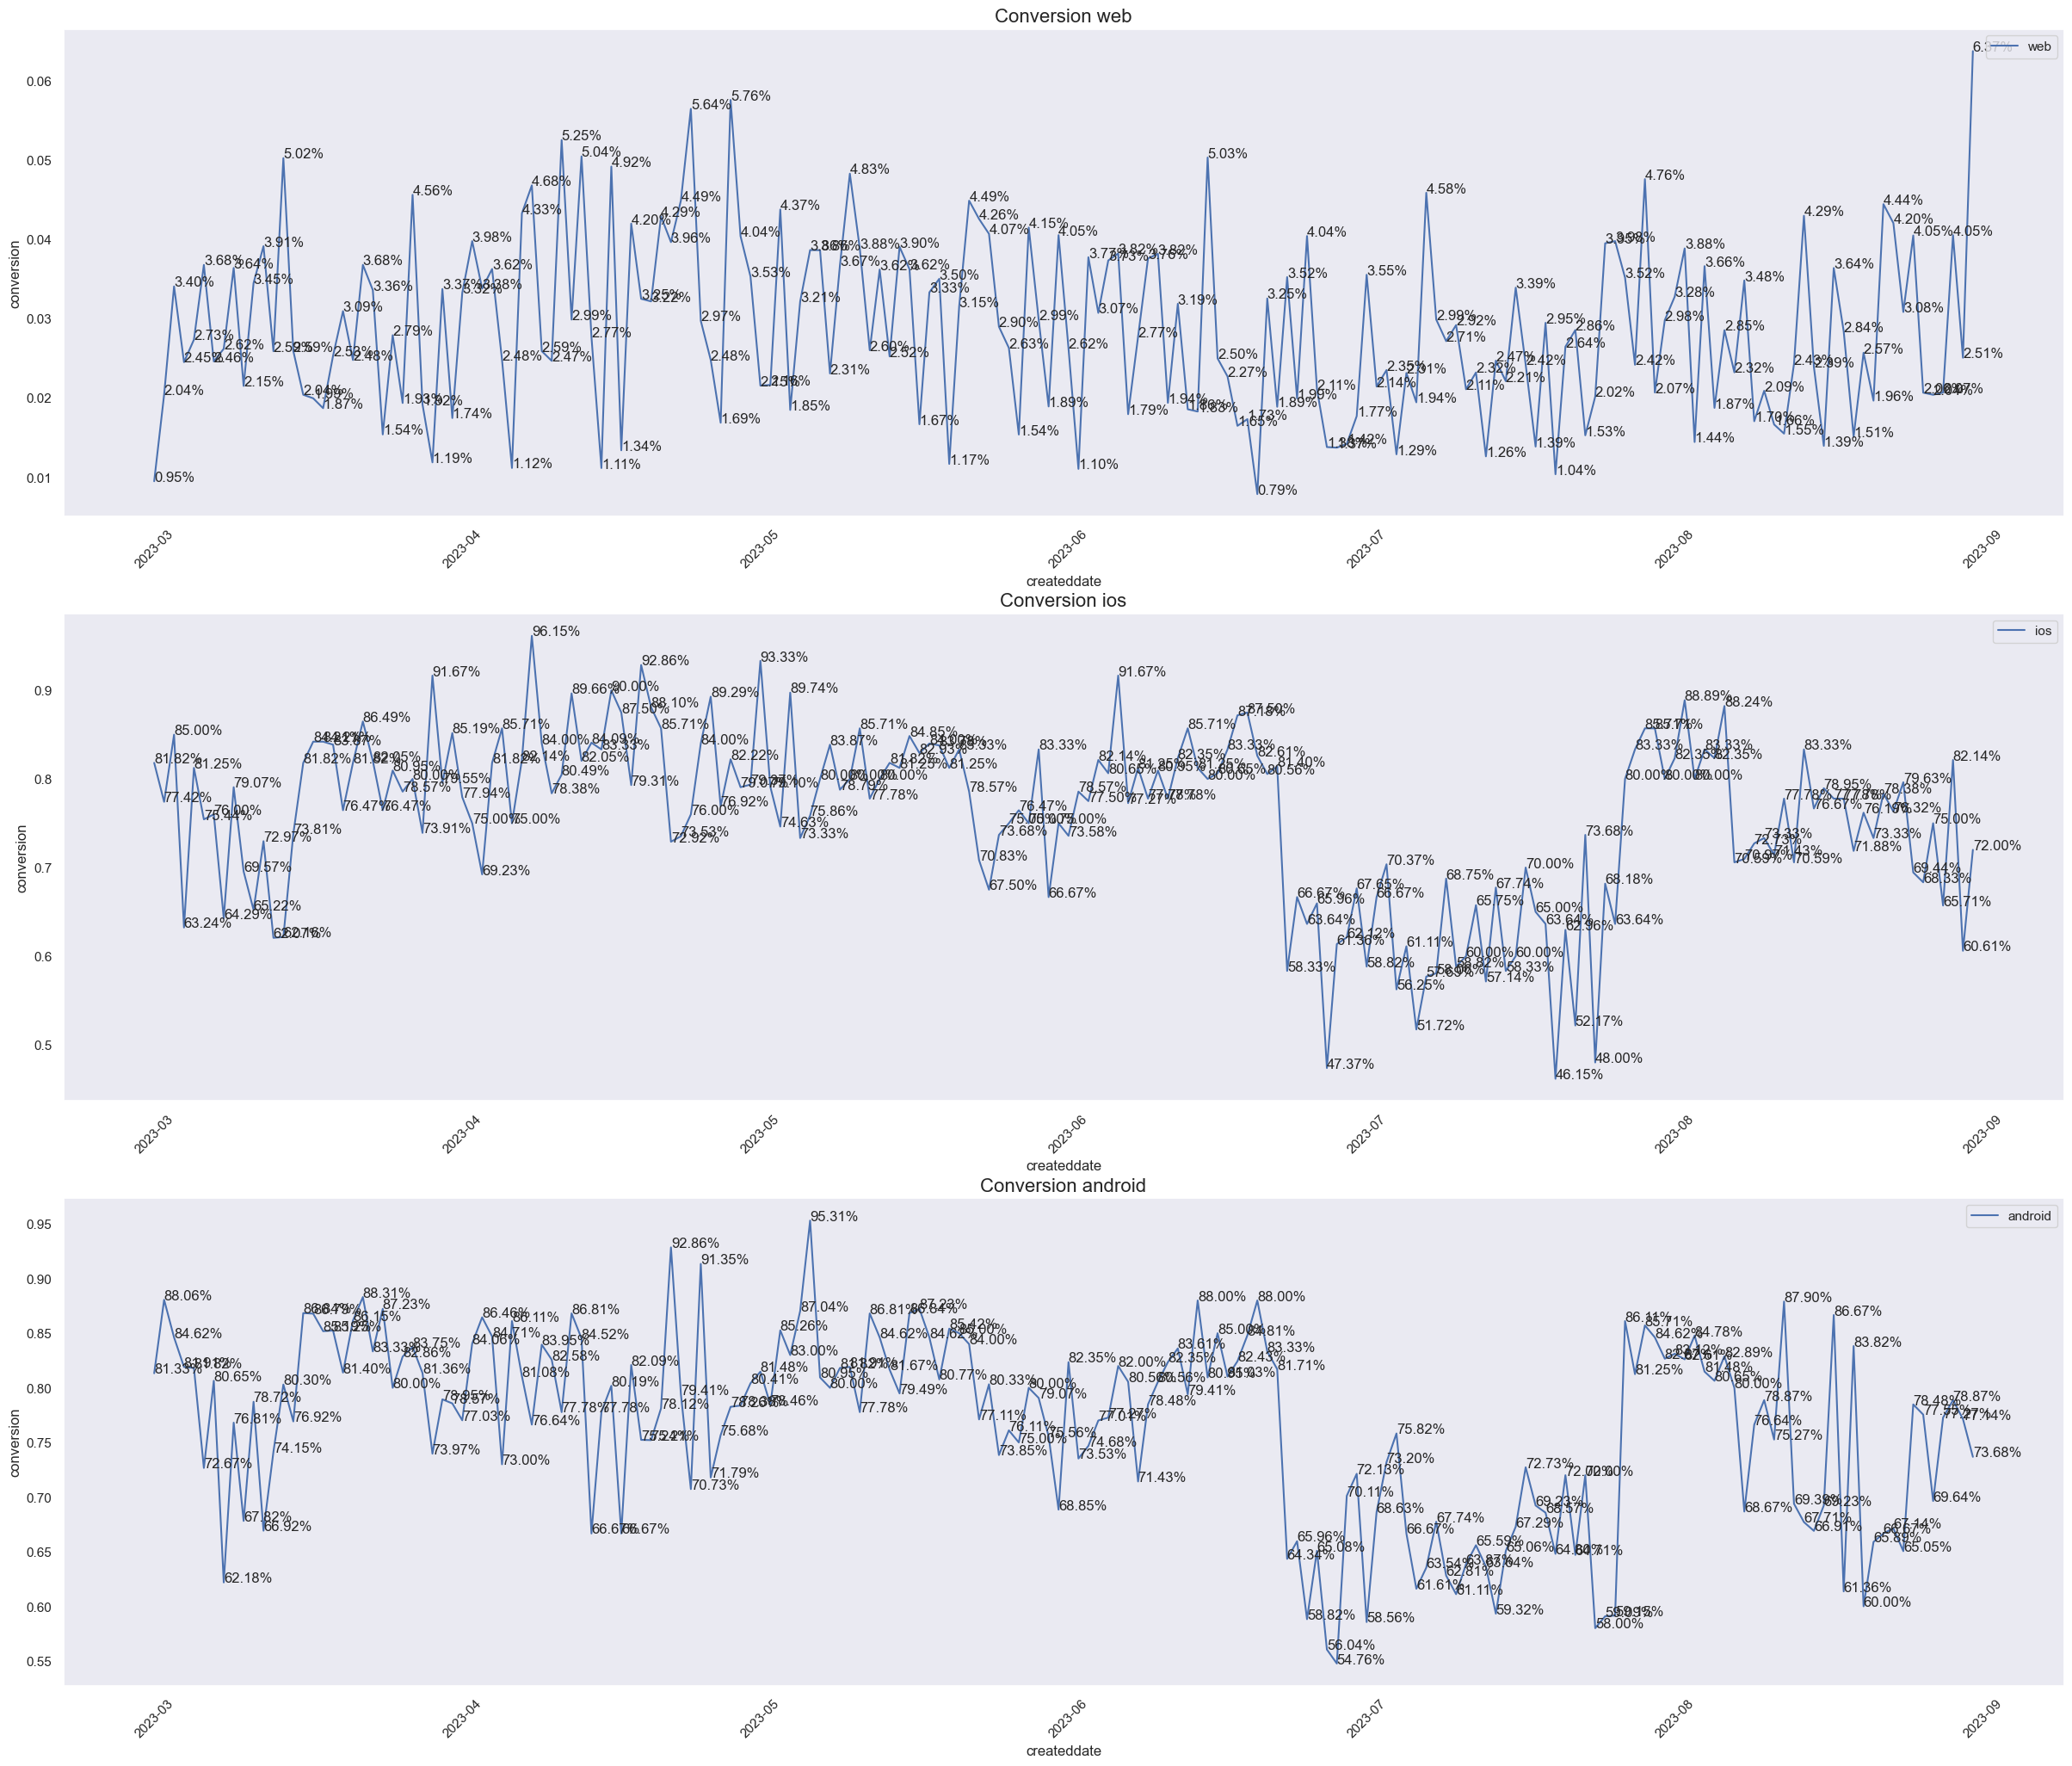

In [541]:
fig, ax = plt.subplots(3,1, figsize = (30,25))
platform = ['web', 'ios', 'android']
for n, z in enumerate(platform):
    ax[n].plot(df_mergedc3['date_group'][df_mergedc3['platform'] == z], df_mergedc3['conversion'][df_mergedc3['platform'] == z], label=z)
    ax[n].set_title(f'Conversion {z}', fontsize=16)
    for i, y in df_mergedc3[df_mergedc3['platform'] == z].iterrows():
        ax[n].text(y['date_group'], y['conversion'], f'{y["conversion"]*100:.2f}%')
    ax[n].set_xlabel('date_group')
    ax[n].set_ylabel('conversion')
    ax[n].tick_params(axis='x', rotation=45)
    ax[n].legend()
    ax[n].grid()
plt.savefig(f'./charts/chart6.png')
plt.show()

    
    

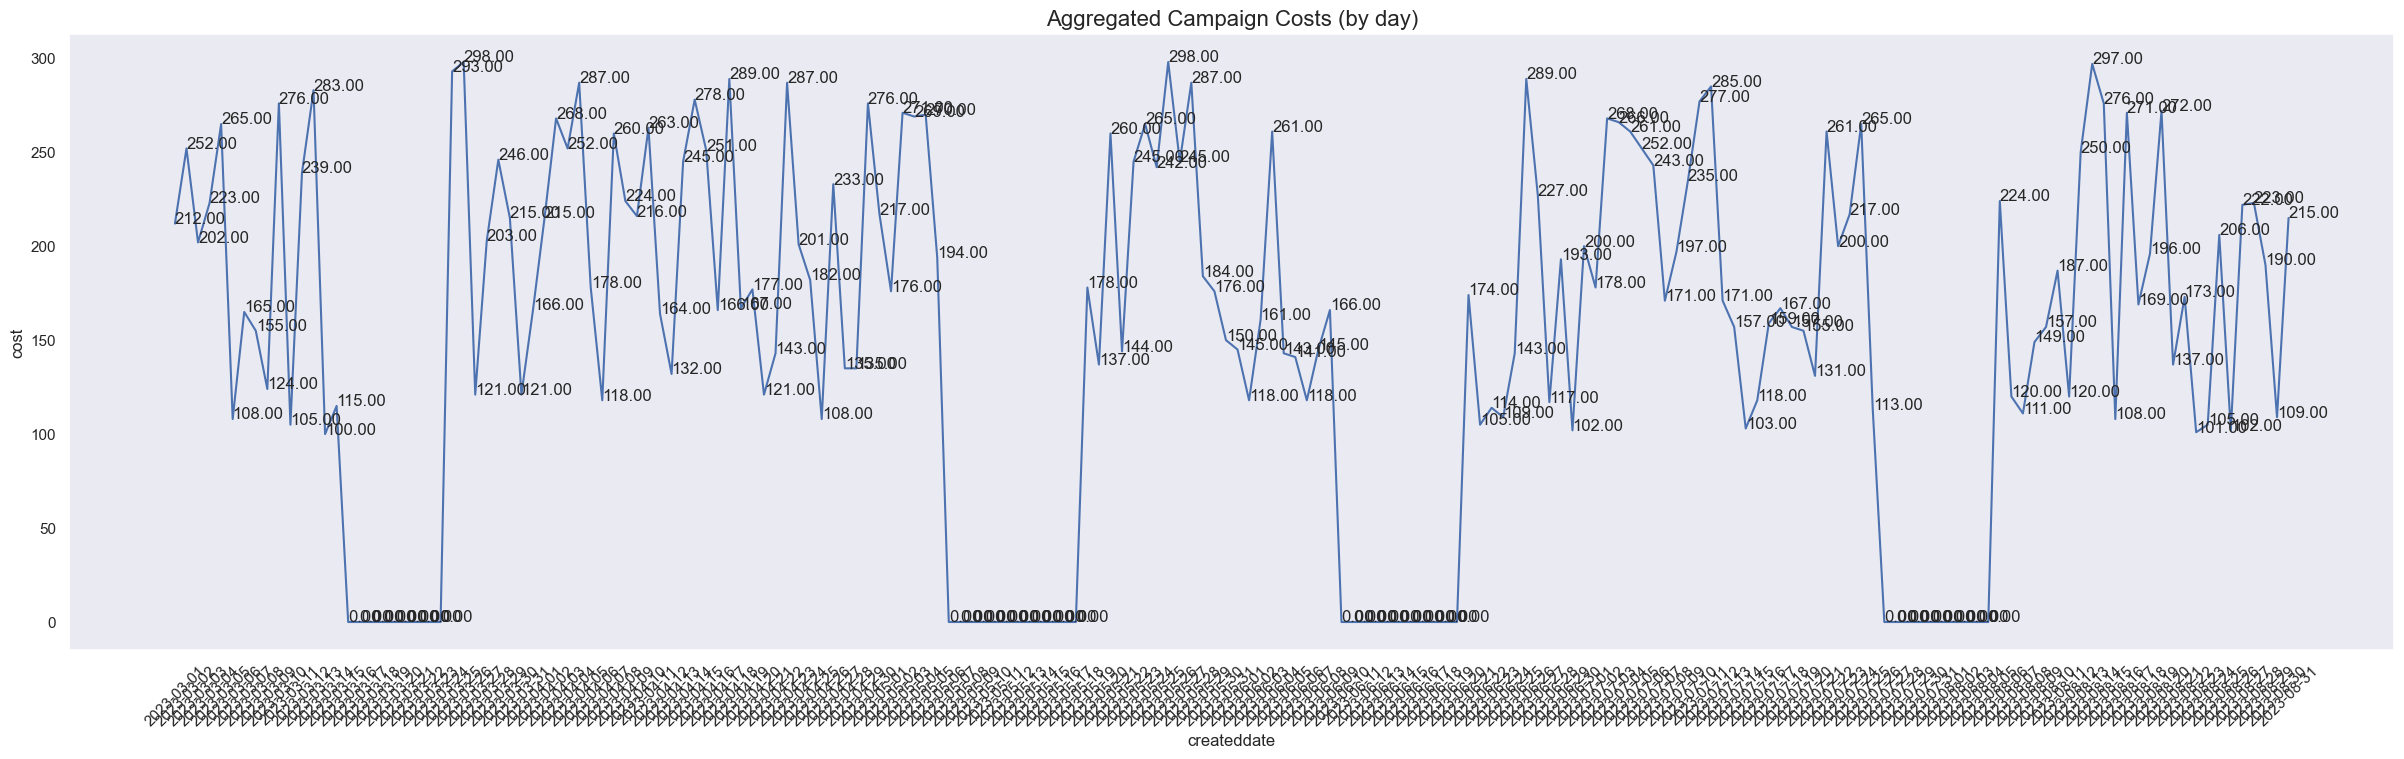

In [543]:
plt.figure(figsize=(30,8))
plt.title('Aggregated Campaign Costs (by day)', fontsize=16)
plt.plot(adsdfmergenona['date_group'], adsdfmergenona['cost'])
for i, y in adsdfmergenona.iterrows():
    plt.text(y['date_group'], y['cost'], f'{y["cost"]:.2f}')
plt.xticks(adsdfmergenona['date_group'], rotation=45)
plt.xlabel('date_group')
plt.ylabel('cost')
plt.grid()
plt.savefig(f'./charts/chart7.png')
plt.show()


In [461]:
dfadscopy = dfads.copy()

In [463]:
dfadscopy = dfadscopy.groupby(['utm_campaign']).agg(mindate=('date_group', 'min'), maxdate=('date_group', 'max')).reset_index()

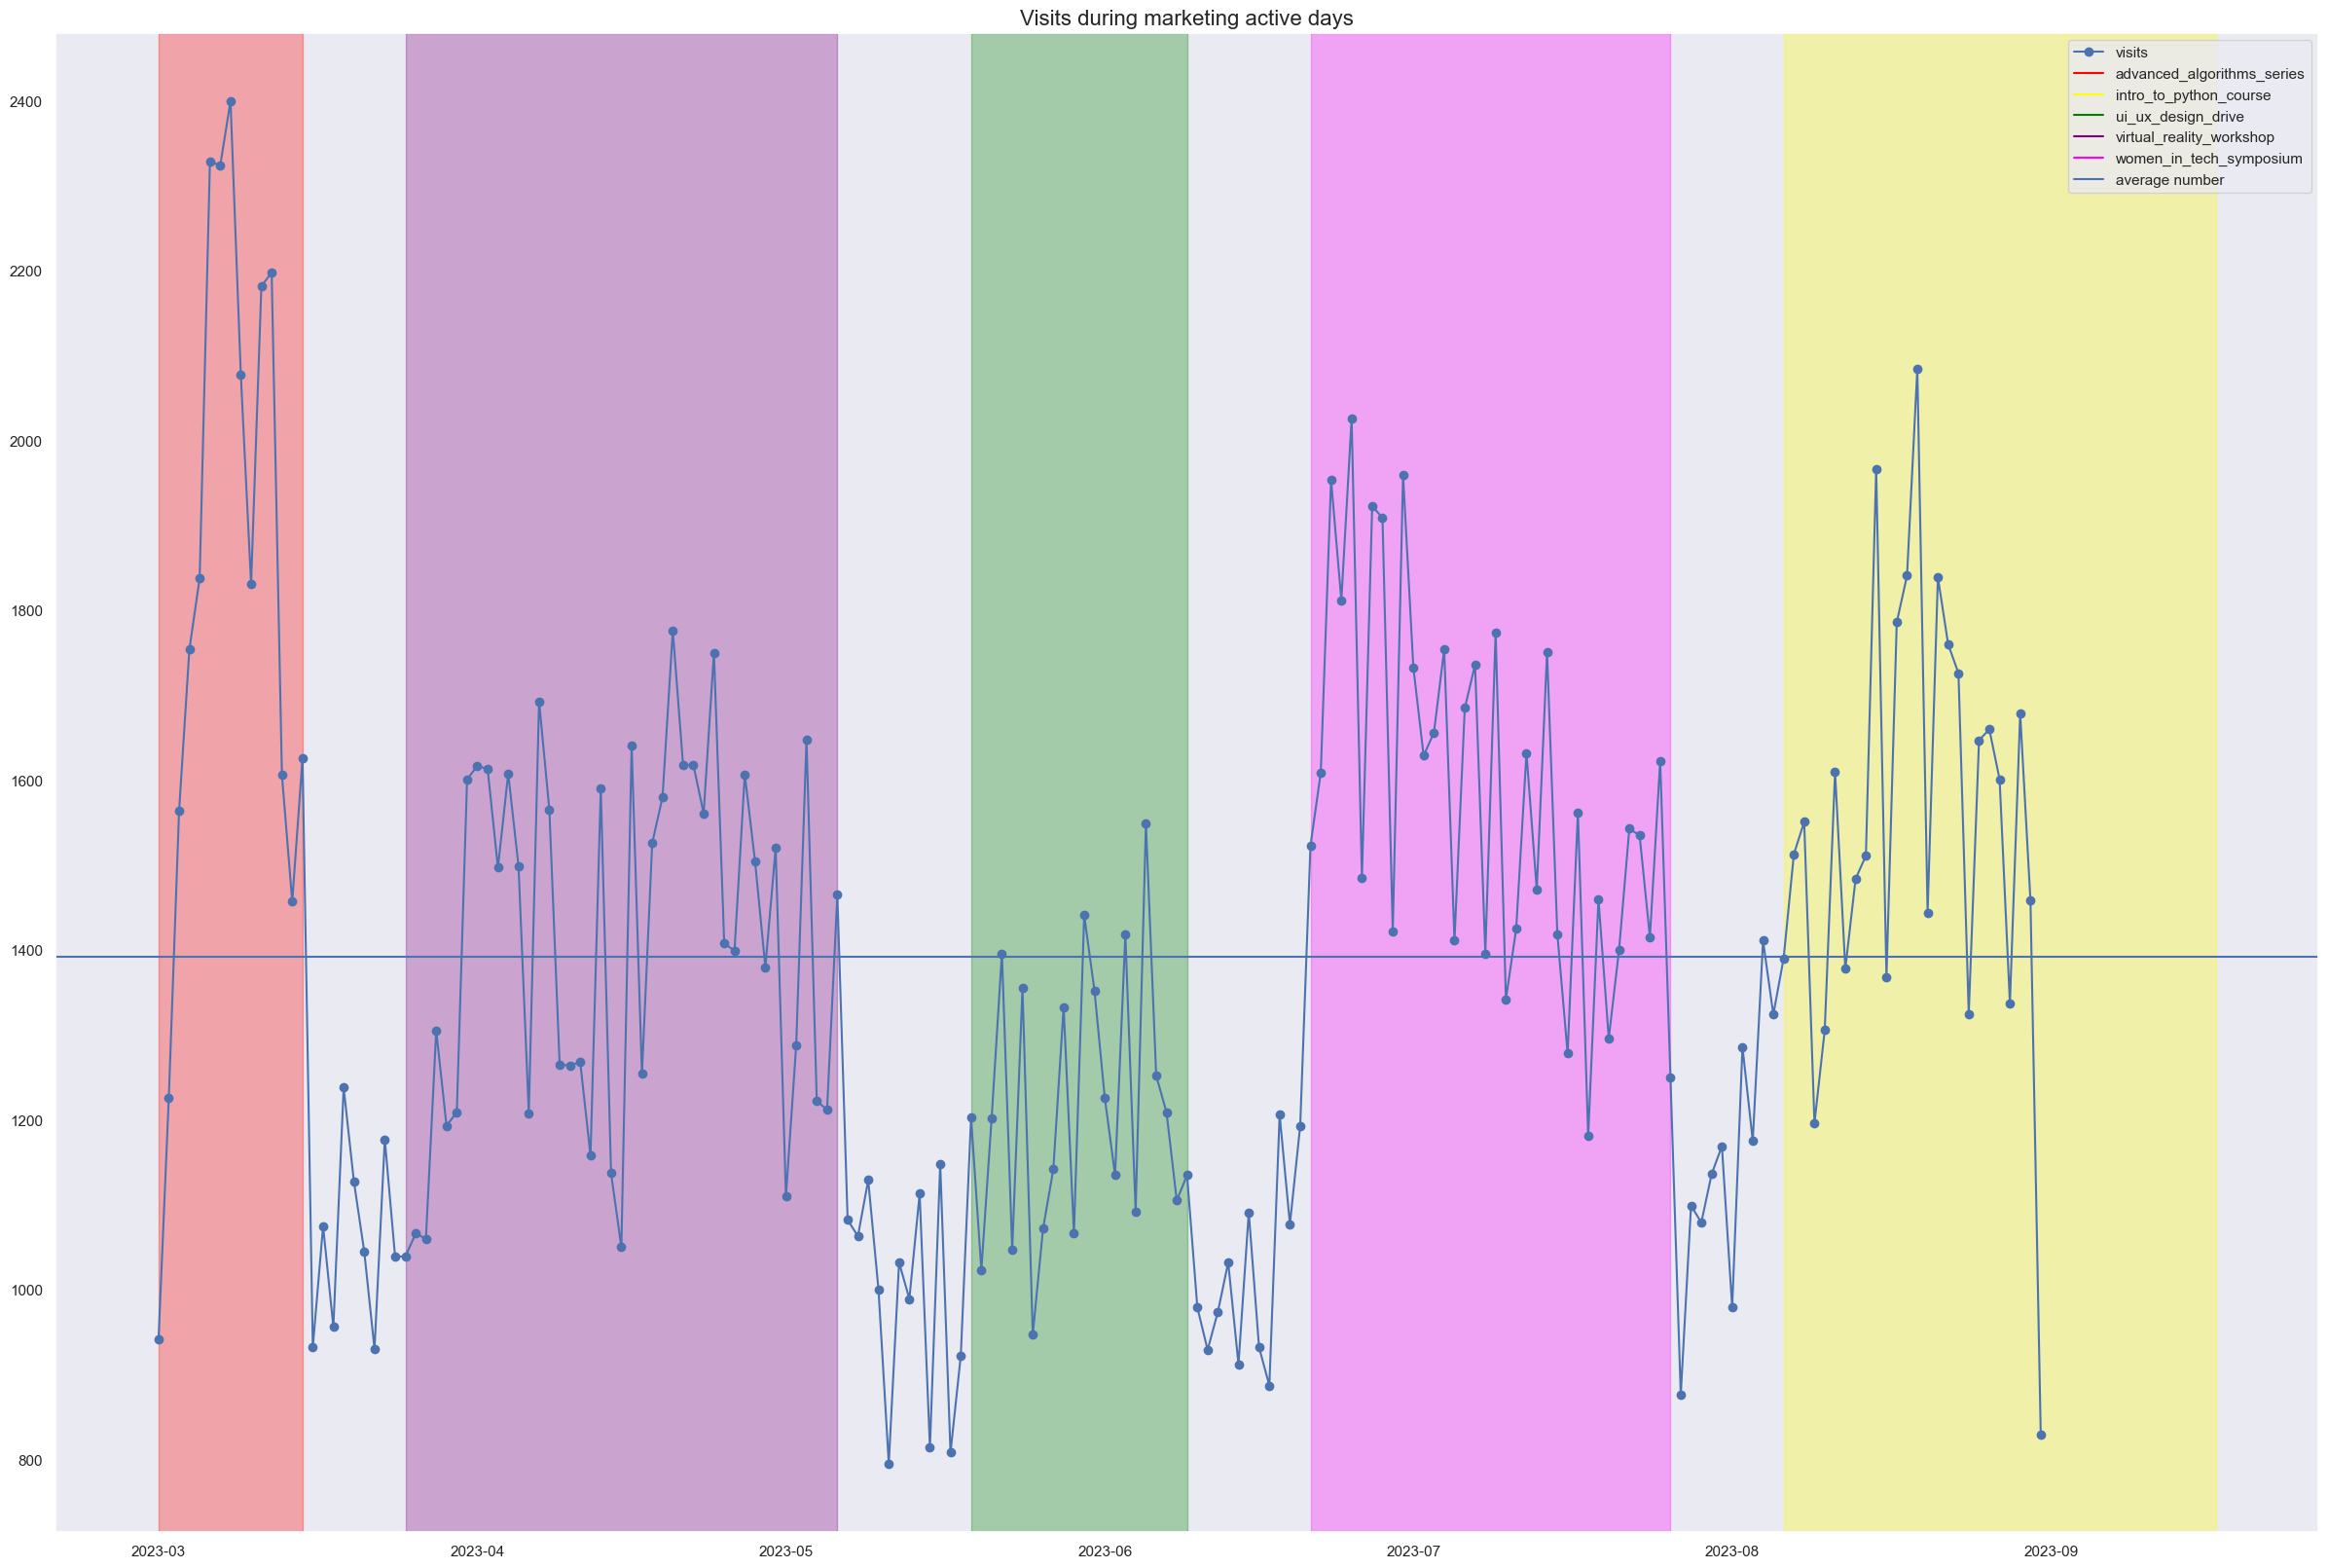

In [545]:
plt.figure(figsize=(30, 20))
colors=['red', 'yellow', 'green', 'purple', 'magenta']
cnt = 0
plt.title('Visits during marketing active days', fontsize=16)
plt.plot(adsdfmerge['date_group'], adsdfmerge['visit_id'], marker='o', label='visits')
for i, y in dfadscopy.iterrows():
    plt.axvspan(xmin=y['mindate'], xmax=y['maxdate'], color=colors[cnt], alpha=0.3)
    plt.plot([], [], color=colors[cnt], label=y['utm_campaign'])
    cnt+=1 
plt.axhline(y=adsdfmerge['visit_id'].mean(), label='average number')
plt.legend()
plt.grid()
plt.savefig(f'./charts/chart8.png')
plt.show()


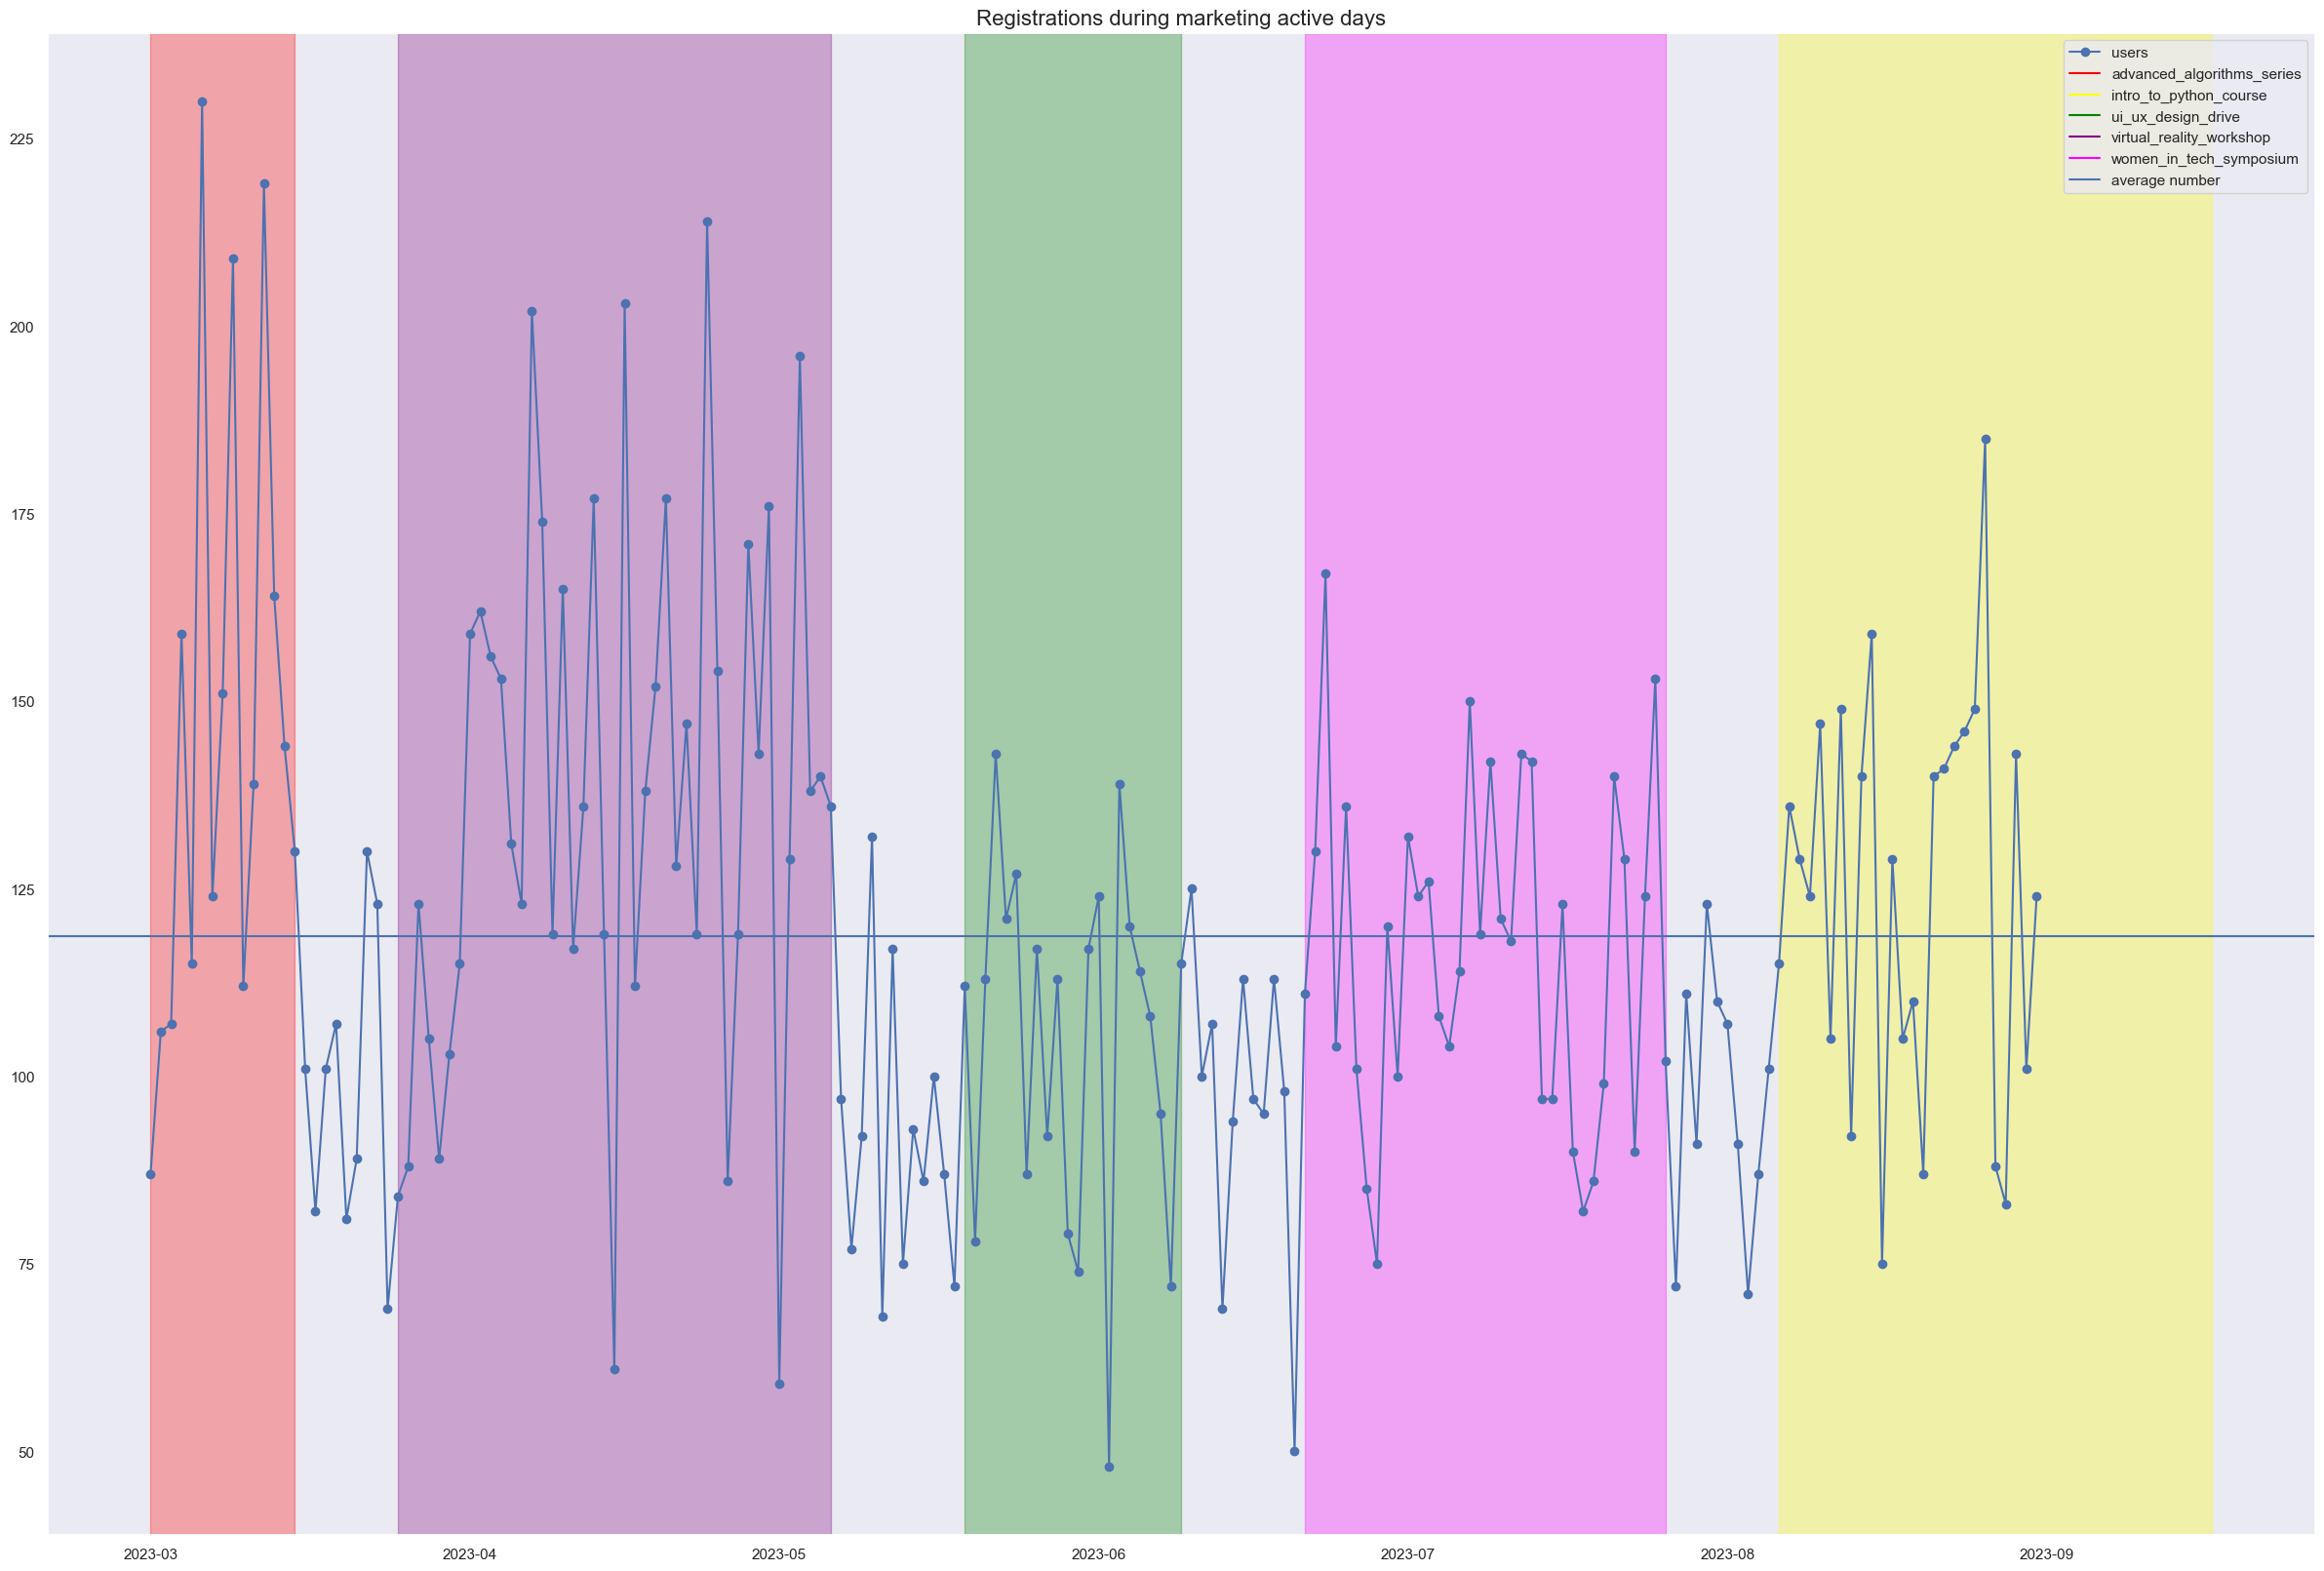

In [547]:
plt.figure(figsize=(30, 20))
colors=['red', 'yellow', 'green', 'purple', 'magenta']
cnt = 0
plt.title('Registrations during marketing active days', fontsize=16)
plt.plot(adsdfmerge['date_group'], adsdfmerge['registrations'], marker='o', label='users')
for i, y in dfadscopy.iterrows():
    plt.axvspan(xmin=y['mindate'], xmax=y['maxdate'], color=colors[cnt], alpha=0.3)
    plt.plot([], [], color=colors[cnt], label=y['utm_campaign'])
    cnt+=1 
plt.axhline(y=adsdfmerge['registrations'].mean(), label='average number')
plt.legend()
plt.grid()
plt.savefig(f'./charts/chart9.png')
plt.show()


In [ ]:
#использовать все графики, описать их, ответить на вопросы в проекте, дать итоговые рекомендации. 